# Constructin an ARIMA model quiz. Champagne Sales

Ucadity Course: https://classroom.udacity.com/courses/ud980/lessons/df9861e4-d359-4662-855f-97b81007efff/concepts/d153fa32-42e9-45ce-87a8-78b9739e3572


## QUIZ QUESTION
Using an ARIMA(1,0,0)(1,1,0)12 model, what is the projected sales value in the final period.

## 1. Understanding the Problem Statement and Dataset
Our data is in a file calld bookings in 'input' directory. We have to:
* Determine how the trend seasonal and error components should be applied (Hint: use the decomposition plot)
*Construct an ETS model, and forecast one period

In [45]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from math import sqrt
from sklearn.metrics import mean_squared_error

#Importing data
df = pd.read_csv('input/champagne-sales.csv')

#Formating month column to date format. Let's guess is 21-century years
def convert_to_year(date_in_some_format):
    month_as_string = str(date_in_some_format[-2:])# last four characters
    year_as_string = "200" + date_in_some_format[0]  
    date = month_as_string + "-" + year_as_string
    return date

df['Month'] = df['Month'].apply(convert_to_year)

#Rename column 'Champagne Sales'
df.rename(columns={'Champagne Sales':'Champagne_Sales'}, inplace=True)
#Printing head
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
Month              96 non-null object
Champagne_Sales    96 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [46]:
#Aggregating the dataset at daily level
df.Timestamp = pd.to_datetime(df.Month,format='%m-%Y') 
df.index = df.Timestamp 
#df = df.resample('M').mean()


/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


## 2. Determine how the trend seasonal and error components should be applied

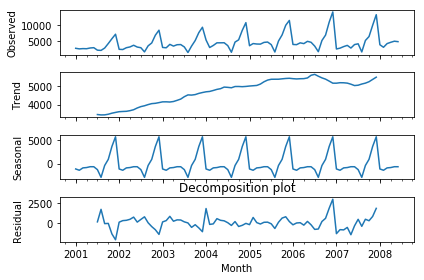

In [47]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train['Champagne_Sales']).plot()

result = sm.tsa.stattools.adfuller(train['Champagne_Sales'])
plt.title('Decomposition plot')
plt.show()

### Solution
1. As the Error is increasing we'll use **multiplicative method**
2. As Trend doesn't increase or decrease exponentially we'll use **none**
3. As Seasonal hasn't constant seasonal components we'll use **multiplicative method**

So, ETS(M,N,M)

## 3. Stationarity
If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

The observations in a stationary time series are not dependent on time.

Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.



## 3a. Checking Stationarity

There are two ways you can check the stationarity of a time series. 
* The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. 

* For a more accurate assessment there is the Dickey-Fuller test. I won’t go into the specifics of this test, but **if the ‘Test Statistic’ is greater than the ‘Critical Value’** than the time series is stationary.

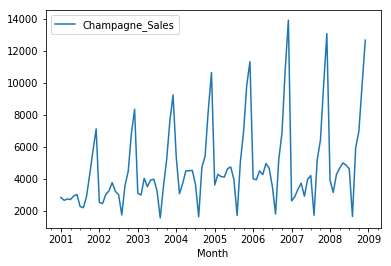

In [48]:
#Checking stationaritiy first way
df.plot()
plt.show()

The dataset is non-stationary as we can see both trend and seasonal components.

In [49]:
#Checking stationarity second way
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


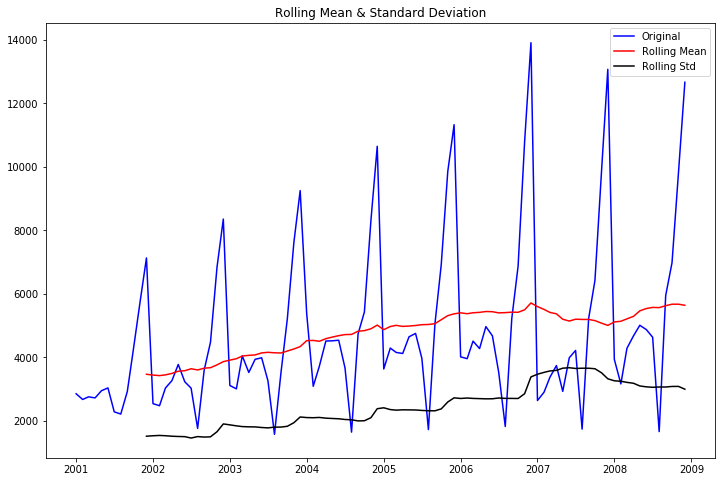

Results of Dickey-Fuller Test:
Test Statistic                 -1.639192
p-value                         0.462683
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [50]:
test_stationarity(df.Champagne_Sales)

As we can see:
Test Statistic is greater than Critical Value, so the **time series is stationary**

## 4. Difference 

If the time series is not stationary, it needs to be stationarized through differencing. 
a. Take the first difference, then check for stationarity. 
b. Take as many differences as it takes. 
c. Make sure you check seasonal differencing as well.

From now on we'll use test_stationarity function to measure stationaryty.

## 4a. First difference
The first thing we want to do is take a first difference of the data. This should help to eliminate the overall trend from the data.



/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


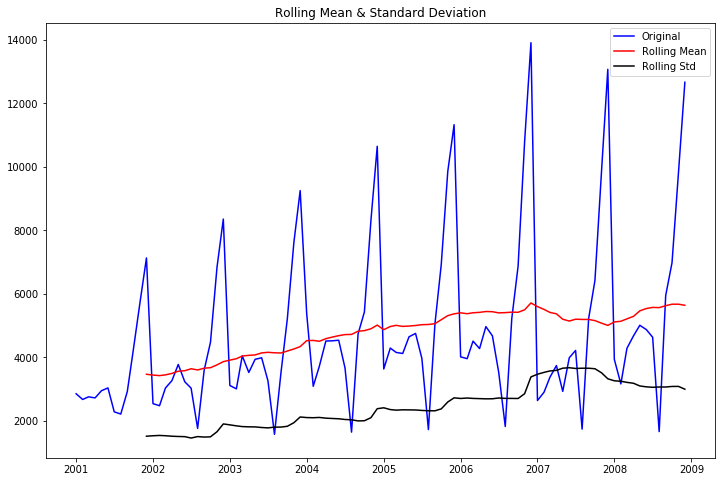

Results of Dickey-Fuller Test:
Test Statistic                 -1.639192
p-value                         0.462683
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [51]:
df['first_difference'] = df.Champagne_Sales - df.Champagne_Sales.shift(1)  
test_stationarity(df.Champagne_Sales.dropna(inplace=False))


## 4b. Take as many differences as it takes
In this case 11.

/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


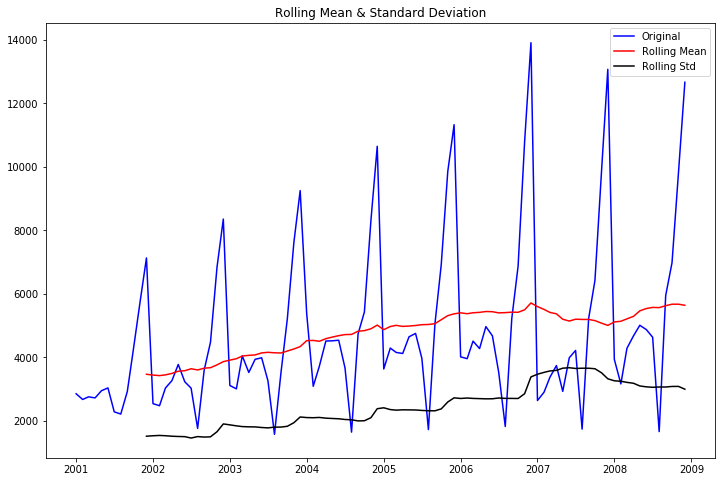

Results of Dickey-Fuller Test:
Test Statistic                 -1.639192
p-value                         0.462683
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [52]:
df['many_differences_as_takes'] = df.Champagne_Sales - df.Champagne_Sales.shift(11)  
test_stationarity(df.Champagne_Sales.dropna(inplace=False))

## 4c. Take a seasonal difference
To remove the seasonality of the data and see how that impacts the stationarity of the data.


/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


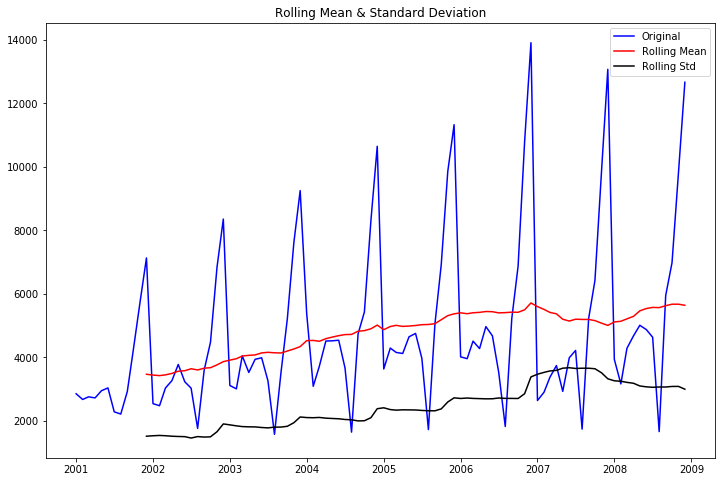

Results of Dickey-Fuller Test:
Test Statistic                 -1.639192
p-value                         0.462683
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [53]:
df['seasonal_difference'] = df.Champagne_Sales - df.Champagne_Sales.shift(12)  
test_stationarity(df.Champagne_Sales.dropna(inplace=False))

## 5. Filter out a validation sample

This will be used to validate how accurate our model is. Use the last 6 periods as the validation sample.

In [54]:
#Creating train and test set 
#Index 120 marks. 96 for train and the rest for test
train=df[0:90] 
test=df[90:]
train.Timestamp = pd.to_datetime(train.Month,format='%m-%Y') 
train.index = train.Timestamp 
#train = train.resample('M').mean() 
test.Timestamp = pd.to_datetime(test.Month,format='%m-%Y') 
test.index = test.Timestamp 
#test = test.resample('M').mean()

/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/home/emi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


Let’s visualize the data (train and test together) to know how it varies over a time period.

/home/emi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


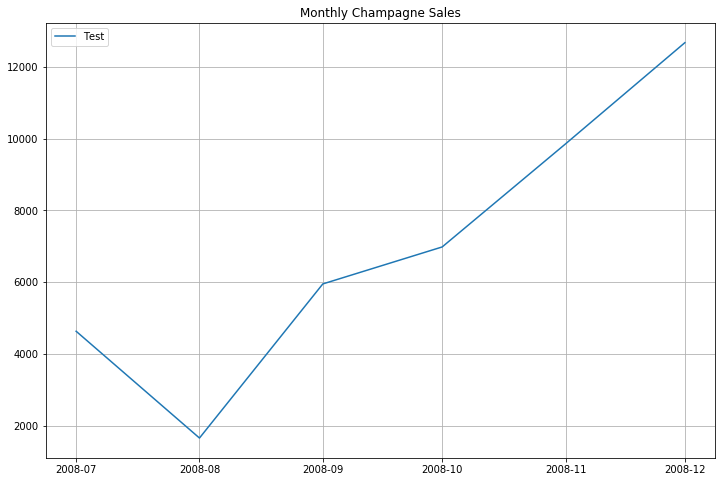

In [55]:
X = train['Champagne_Sales'].count
Y = test['Champagne_Sales'].count
plt.figure(figsize=(12,8))

#plt.plot(train.index, train['Champagne_Sales'], label='Train')
plt.plot(test.index,test['Champagne_Sales'], label='Test')
plt.legend(loc='best')
plt.title("Monthly Champagne Sales")
plt.grid('on')
plt.show()

## 6. Select AR and MA terms

Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.

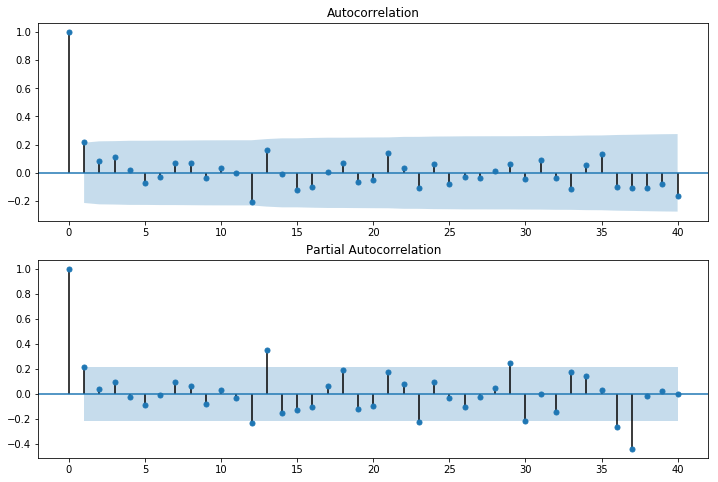

In [57]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_difference.iloc[12:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_difference.iloc[12:], lags=40, ax=ax2)

We see the PACF drops off after Lag-1, which confirms that our series suggest an **AR-1 model**.


## 7. Build the model

Build the model and set the number of periods to forecast to 6.

The parameters for the model ((1,0,0)x(1,1,0,12)

In [68]:
mod = sm.tsa.statespace.SARIMAX(df.Champagne_Sales, trend='n', order=(1,0,0), seasonal_order=(1,1,0,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    Champagne_Sales   No. Observations:                   96
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -681.497
Date:                            Fri, 20 Jul 2018   AIC                           1368.994
Time:                                    21:43:44   BIC                           1376.287
Sample:                                01-01-2001   HQIC                          1371.926
                                     - 12-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3071      0.072      4.262      0.000       0.166       0.448
ar.S.L12      -0.1000      0.091   

/home/emi/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## 8. Validate model

Compare the predicted values to the actuals in the validation sample.

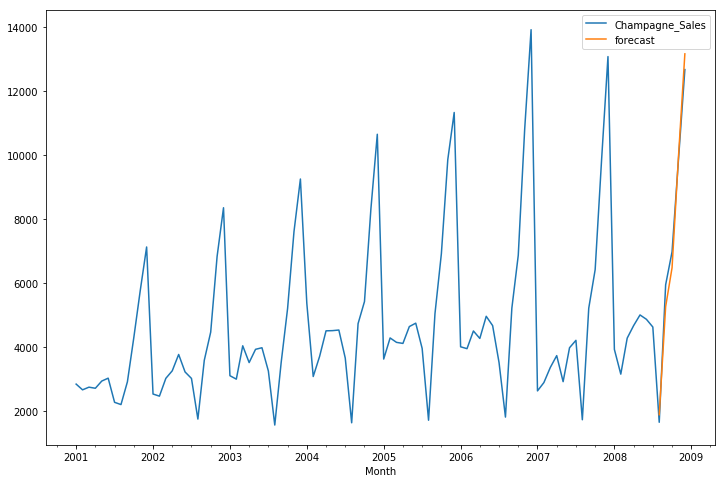

In [69]:
df['forecast'] = results.predict(start = 91, end= 96, dynamic= True)  
df[['Champagne_Sales', 'forecast']].plot(figsize=(12, 8))


## QUIZ RESULT 

In [70]:
print(df.forecast[-1])

13161.340049575902
